# NCI WeatherBench-3a: Train a CNN

In this notebook we will go through all the steps required to train a fully convolutional neural network. Because this takes a while and uses a lot of GPU RAM a separate command line script (`train_nn.py`) is also provided in the `src` directory.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from score import *
from collections import OrderedDict
from dask.diagnostics import ProgressBar
from datetime import datetime
from dask.distributed import Client

2024-03-26 21:03:38.591466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
client = Client(n_workers=12, threads_per_worker=1)  
client

[2024-03-26 21:03:40]


/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 191.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38091,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 191.00 GiB
Comm: tcp://127.0.0.1:37387,Total threads: 1
Dashboard: /proxy/41997/status,Memory: 15.92 GiB
Nanny: tcp://127.0.0.1:43765,


In [3]:
tf.__version__

'2.13.0'

In [4]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)
    
limit_mem()    

2024-03-26 21:03:42.937450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


In [5]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [6]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
res = '5.625'
print ('res:', res)
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print('DATADIR:', DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print('PREDDIR:', PREDDIR)
! mkdir -p {PREDDIR} 
! mkdir -p {PREDDIR+"/saved_models"} 

[2024-03-26 21:03:43]
res: 5.625
DATADIR: /g/data/wb00/NCI-Weatherbench/5.625deg
PREDDIR: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir


## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [7]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
valid_years = list(range( 2021, 2022+1))
print (valid_years)
z500_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*') ] 
t850_valid_files = [ file for year in valid_years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')  ] 

z500_valid = load_test_data(z500_valid_files, 'z', slice('2021', '2022')).load()  
t850_valid = load_test_data(t850_valid_files, 't', slice('2021', '2022')).load() 
valid = xr.merge([z500_valid, t850_valid]).compute()

[2024-03-26 21:03:43]
[2021, 2022]
load_test_data, var: z
load_test_data, var: t
CPU times: user 6.27 s, sys: 755 ms, total: 7.02 s
Wall time: 8.25 s


In [8]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
years = list(range(1999, 2022+1))
print (years)
z_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/geopotential/*{year}*')  ] 
t_files = [ file for year in years for file in glob.glob (fr'{DATADIR}/temperature/*{year}*')    ] 

z = xr.open_mfdataset(z_files, combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=[500]).load()    
t = xr.open_mfdataset(t_files, combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=[850]).drop('level').load()  

[2024-03-26 21:03:51]
[1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
CPU times: user 50 s, sys: 4.83 s, total: 54.8 s
Wall time: 56.1 s


In [9]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
datasets = [z, t]
ds = xr.merge(datasets).compute()

[2024-03-26 21:04:48]
CPU times: user 4.06 ms, sys: 677 µs, total: 4.74 ms
Wall time: 3.63 ms


In [10]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
ds_train = ds.sel(time=slice( '1999', '2020' ))   
ds_test  = ds.sel(time=slice( '2021', '2022' ))  

[2024-03-26 21:04:48]
CPU times: user 11.6 ms, sys: 589 µs, total: 12.2 ms
Wall time: 9.37 ms


In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
       
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            print (f"({var}, {levels})")
            try:
                data.append(ds[var].sel(level=levels))               
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))
            #except KeyError:  
            #    data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [12]:
dic = OrderedDict({'z': 500, 't': 500})

In [13]:
# Batch zise and lead time
bs=32
lead_time=6

In [14]:
ds_train

<xarray.Dataset>
Dimensions:  (level: 1, time: 192864, lat: 32, lon: 64)
Coordinates:
  * level    (level) int32 500
  * time     (time) datetime64[ns] 1999-01-01 ... 2020-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, level, lat, lon) float32 5.016e+04 5.017e+04 ... 5.151e+04
    t        (time, level, lat, lon) float32 254.1 254.5 254.7 ... 261.8 261.4

In [15]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
print ('Start year: 1999')
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1999', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2020')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

[2024-03-26 21:04:48]
Start year: 1999
(z, 500)
(t, 500)
Loading data into RAM
(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 19 s, sys: 3.08 s, total: 22.1 s
Wall time: 17.7 s


In [16]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54140.027  ,   274.65103], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500,
 <xarray.DataArray 'z' (level: 2)>
 array([1100.1848  ,    5.642098], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500)

In [17]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

[2024-03-26 21:05:06]
(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 201 ms, sys: 160 ms, total: 360 ms
Wall time: 272 ms


## Create and train model

Next up, we need to create the model architecture. 
- Here we will use a fully connected convolutional network. Because the Earth is periodic in longitude, we want to use a periodic convolution in the lon-direction. 
- This is not implemented in Keras, so we will do it manually.

In [18]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [19]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [20]:
import tensorflow as tf
from keras import backend as K
print(K.backend())
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

tensorflow
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))

[2024-03-26 21:05:06]
CPU times: user 216 ms, sys: 25 ms, total: 241 ms
Wall time: 207 ms


2024-03-26 21:05:06.948772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3e:00.0, compute capability: 7.0


In [22]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

[2024-03-26 21:05:07]
CPU times: user 10.8 ms, sys: 1.64 ms, total: 12.4 ms
Wall time: 10.3 ms


In [23]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 periodic_conv2d (PeriodicC  (None, 32, 64, 64)        3264      
 onv2D)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_1 (Periodi  (None, 32, 64, 64)        102464    
 cConv2D)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_2 (Periodi  (None, 32, 64, 64)        102464

In [24]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Since we didn't load the full data, this is only for demonstration.
cnn.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1, 
                        mode='auto'
                    )]
         )

[2024-03-26 21:05:07]
Epoch 1/100


2024-03-26 21:05:08.369470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-03-26 21:05:08.794041: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55acf5795540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-26 21:05:08.794056: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-03-26 21:05:08.798164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-26 21:05:08.960991: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4657/4657 [==============================] - 75s 16ms/step - loss: 0.0709 - val_loss: 0.0407
Epoch 2/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0380 - val_loss: 0.0367
Epoch 3/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0353 - val_loss: 0.0349
Epoch 4/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0337 - val_loss: 0.0344
Epoch 5/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0326 - val_loss: 0.0328
Epoch 6/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0319 - val_loss: 0.0332
Epoch 7/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0312 - val_loss: 0.0314
Epoch 8/100
2653/4657 [================>.............] - ETA: 26s - loss: 0.0308

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4657/4657 [==============================] - 72s 15ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 10/100
4657/4657 [==============================] - 71s 15ms/step - loss: 0.0299 - val_loss: 0.0302
Epoch 11/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0295 - val_loss: 0.0301
Epoch 12/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0293 - val_loss: 0.0295
Epoch 13/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0290 - val_loss: 0.0293
Epoch 14/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0287 - val_loss: 0.0296
Epoch 15/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0285 - val_loss: 0.0293
Epoch 16/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0282 - val_loss: 0.0296
Epoch 17/100
4657/4657 [==============================] - 72s 15ms/step - loss: 0.0280 - val_loss: 0.0288
Epoch 18/100
4657/4657 [==============================] - 7

## Create predictions

Now that we have our model we need to create a prediction NetCDF file. This function does this. 

We can either directly predict the target lead time (e.g. 5 days) or create an iterative forecast by chaining together many e.g. 6h forecasts.

In [25]:
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict_generator(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None or isinstance(levels, int):
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [26]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
fc = create_predictions(cnn, dg_test)

[2024-03-26 21:56:25]
CPU times: user 6.83 s, sys: 961 ms, total: 7.79 s
Wall time: 4.54 s


In [27]:
print( valid['time'])
print(    fc['time'])

<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T06:00:00.000000000', '2021-01-01T07:00:00.000000000',
       '2021-01-01T08:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T06:00:00 ... 2022-12-31T23:00:00


In [28]:
%%time
rmse_1 = compute_weighted_rmse(fc, valid).compute()
print (rmse_1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 103.3
    t        float64 1.114
CPU times: user 707 ms, sys: 446 ms, total: 1.15 s
Wall time: 927 ms


### Iterative predictions

In [29]:
def create_iterative_predictions(model, dg, max_lead_time=5*24):
    state = dg.data[:dg.n_samples]
    preds = []
    for _ in range(max_lead_time // dg.lead_time):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None or isinstance(levels, int):
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

In [30]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
fc_iter = create_iterative_predictions(cnn, dg_test)

[2024-03-26 21:56:31]
548/548 [==============================] - 3s 5ms/step
CPU times: user 1min 41s, sys: 18.8 s, total: 2min
Wall time: 1min 31s


In [31]:
print (fc_iter['time'])
print (  valid['time'])

<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T15:00:00.000000000',
       '2022-12-31T16:00:00.000000000', '2022-12-31T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00


In [32]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t = evaluate_iterative_forecast(fc_iter, valid, compute_weighted_rmse)

[2024-03-26 21:58:03]
Merging ...
CPU times: user 15.3 s, sys: 9.83 s, total: 25.1 s
Wall time: 20.4 s


In [33]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t.load()

[2024-03-26 21:58:23]
CPU times: user 265 µs, sys: 37 µs, total: 302 µs
Wall time: 262 µs


<xarray.Dataset>
Dimensions:    (lead_time: 20)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time) float64 103.3 159.2 219.6 ... 1.223e+03 1.261e+03
    t          (lead_time) float64 1.114 1.473 1.692 1.869 ... 4.711 4.86 4.998

[2024-03-26 21:58:23]


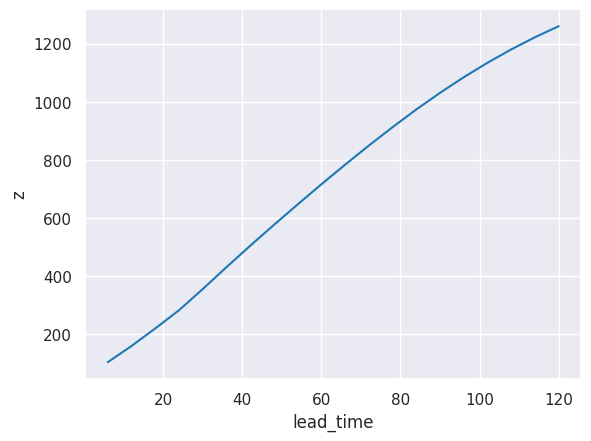

In [34]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t.z.plot()

[2024-03-26 21:58:24]


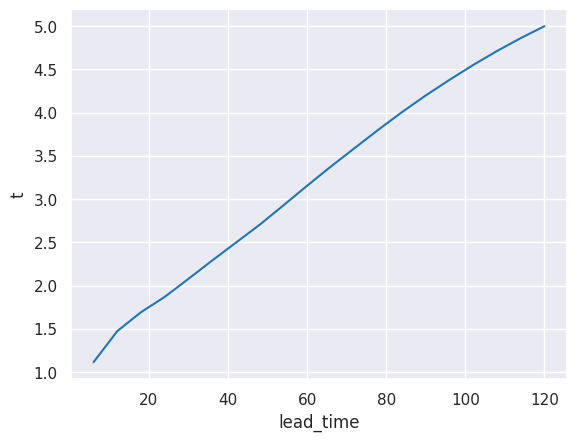

In [35]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
rmse_z_t.t.plot()

# The end